In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from matplotlib import cm
import tensorflow_io as tfio

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

AUTOTUNE = tf.data.AUTOTUNE
IS_TRIMMED = False
HAS_FADE = False
SPECTROGRAM_TYPE = False # 'mel' 'log_mel' 'mfcc'


In [2]:
data_dir = pathlib.Path('data/geo_augmented')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)

num_samples = len(filenames)
val_num = num_samples * 10 // 100
test_num = num_samples * 10 // 100
train_num = num_samples - val_num - test_num

train_files = filenames[:train_num]
val_files = filenames[train_num: train_num + val_num]
test_files = filenames[-test_num:]

print('სიტყვები  :', commands)
print('სულ       :', len(filenames))
print('საწრთვნელი:', len(train_files))
print('ვალიდაციის:', len(val_files))
print('სატესტო   :', len(test_files))

სიტყვები  : ['ზევით' 'უკან' 'მარცხნივ' 'ქვევით' 'მარჯვნივ' 'წინ']
სულ       : 3547
საწრთვნელი: 2839
ვალიდაციის: 354
სატესტო   : 354


In [4]:
def trim(audio, eps):
    position = tfio.audio.trim(audio, axis=0, epsilon=eps)

    start = position[0]
    stop = position[1]
    
    return audio[start:stop]

def decode_audio(audio_binary, eps=0.1):
    audio, _ = tf.audio.decode_wav(audio_binary)
    audio = tf.squeeze(audio, axis=-1)
    
    if IS_TRIMMED:
        audio = trim(audio, eps)
    
    if HAS_FADE: 
        audio = tfio.audio.fade(
            audio, fade_in=1000, fade_out=3000, mode="logarithmic")    

    return audio

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)
    stfts = tf.signal.stft(equal_length, frame_length=255, frame_step=128, fft_length=256)

    spectrograms = tf.abs(stfts)
    
    if not SPECTROGRAM_TYPE:
        return spectrograms

    batch_size, num_samples, sample_rate = 32, 16000, 16000.0

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, 
        num_spectrogram_bins, 
        sample_rate, 
        lower_edge_hertz,
        upper_edge_hertz)

    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)

    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    if SPECTROGRAM_TYPE == 'mel': 
        return tf.abs(mel_spectrograms)
    
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    
    if SPECTROGRAM_TYPE == 'log_mel':
        return tf.abs(log_mel_spectrograms)
    
    # Compute MFCCs from log_mel_spectrograms.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]

    return tf.abs(mfccs)

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = waveform_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds, waveform_ds

def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='auto')

In [5]:
train_ds, waveform_ds = preprocess_dataset(train_files)
test_ds, _ = preprocess_dataset(test_files)
val_ds, _ = preprocess_dataset(val_files)

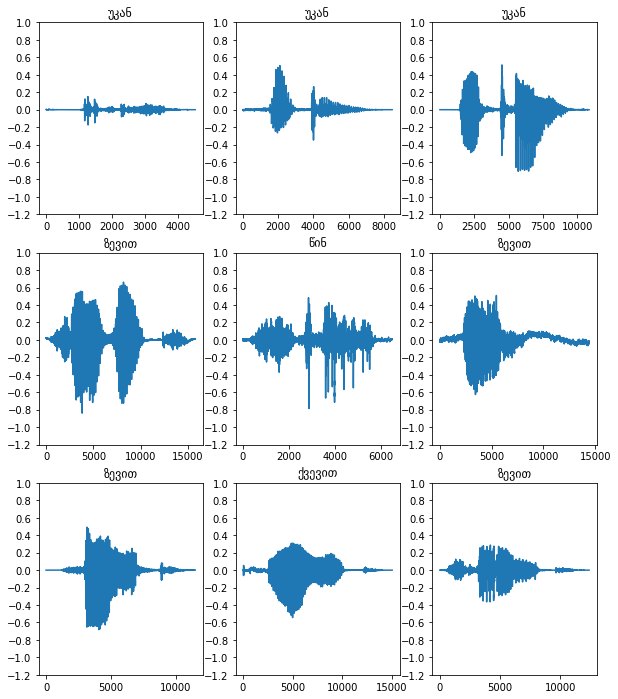

In [6]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


<ipython-input-4-0f9f31a815e9>:91: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


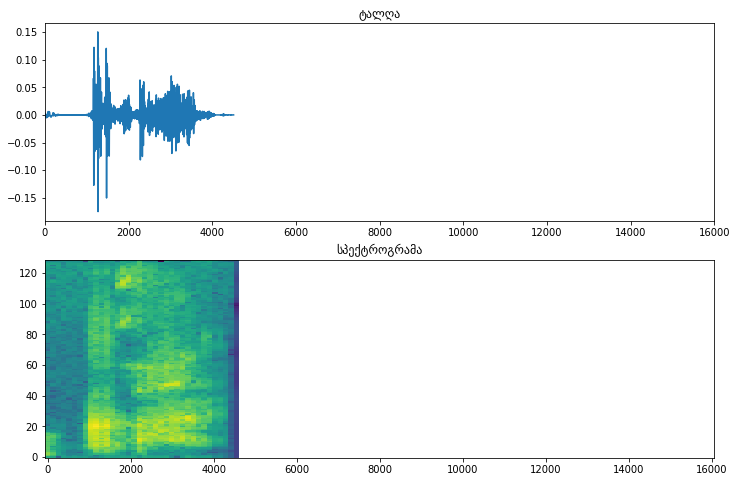

In [7]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('ტალღა')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('სპექტროგრამა')
plt.show()

<ipython-input-4-0f9f31a815e9>:91: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


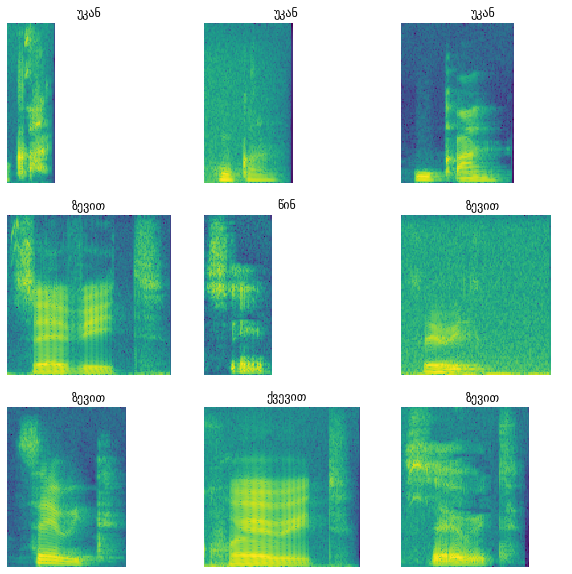

In [8]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [9]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

# model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
#                                                include_top=True,
#                                                weights=None,
#                                                classes=num_labels
#                                                )


model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [10]:
batch_size = 64

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [12]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
45/45 [==============================] - 7s 143ms/step - loss: 0.6149 - accuracy: 0.7753 - val_loss: 0.2093 - val_accuracy: 0.9379
Epoch 2/10
45/45 [==============================] - 5s 104ms/step - loss: 0.1959 - accuracy: 0.9338 - val_loss: 0.1155 - val_accuracy: 0.9661
Epoch 3/10
45/45 [==============================] - 5s 102ms/step - loss: 0.1317 - accuracy: 0.9584 - val_loss: 0.1026 - val_accuracy: 0.9746
Epoch 4/10
45/45 [==============================] - 5s 102ms/step - loss: 0.0996 - accuracy: 0.9683 - val_loss: 0.0787 - val_accuracy: 0.9718
Epoch 5/10
45/45 [==============================] - 5s 103ms/step - loss: 0.0692 - accuracy: 0.9782 - val_loss: 0.0913 - val_accuracy: 0.9831
Epoch 6/10
45/45 [==============================] - 5s 108ms/step - loss: 0.0449 - accuracy: 0.9845 - val_loss: 0.0677 - val_accuracy: 0.9887
Epoch 7/10
45/45 [==============================] - 5s 107ms/step - loss: 0.0479 - accuracy: 0.9852 - val_loss: 0.0487 - val_accuracy: 0.9944
Epoch 

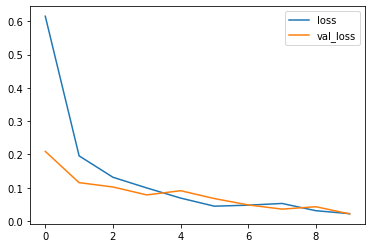

In [13]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

სიზუსტე სატესტო მასალაზე: 99%


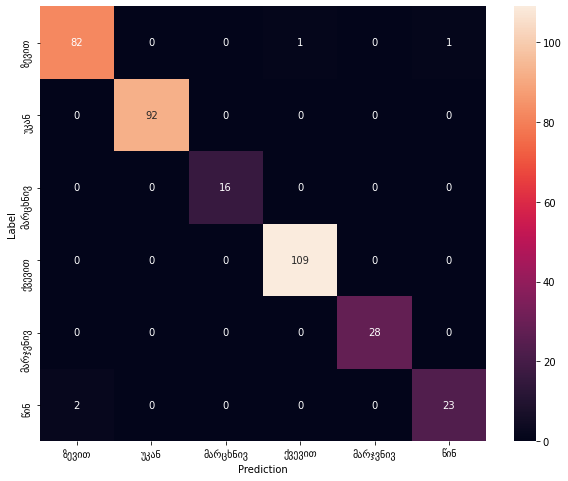

In [14]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'სიზუსტე სატესტო მასალაზე: {test_acc:.0%}')


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [15]:
# save model to a file
!mkdir -p saved_model
model.save('models/saved_model')


INFO:tensorflow:Assets written to: models/saved_model/assets
